# Lane Detection Using OpenCV

The purpose of this notebook is to explore common `OpenCV` functions and dig into the fundamentals of lane detection.

## Imports

In [17]:
import cv2
import numpy as np
from IPython.display import Video
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from functions import *
%matplotlib inline

## Read Image

Read in an image showing an example of highway driving. From the image below we can see that the right line is solid and the left line is dashed with reflective markers in-between the dashes. The scenario we are examining is an ideal situation. The lines are clear and easy to read, there are no other markings or objects on the road ahead of us, and the road is straight. Thought such a case is simple, it provides a good foundation to understand lane detection.

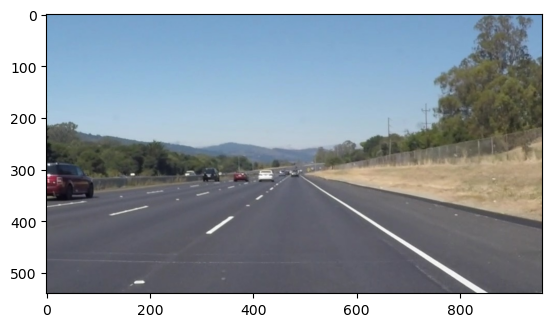

In [2]:
img = cv2.imread('test_images/solidWhiteRight.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

## Transformations

### Canny Edge Detection

The first step in the lane detection problem is to identify the edges, or boundries, of the features in our image. Specifically, we want to see if we can find the edges of the lines on the road. Canny edge detection is a fundamental method of edge detection that is based on the idea of calculating the gradient between subsequent pixel intensities.

First we can convert the image to multi-channel into single-channel by applying a grayscale transformation as we want to focus on the average intensity instead of a color-specific intensity of a pixel.

Next a Gaussian filter is applied to reduce the noise in the image and make the gradient calculation less susceptible to noise.

A **Sobel kernal** is then applied vertically and horizontally to calculate the first derivatives. The resulting two derived images allow us to apply the edge gradient calculation.

The image is then scanned to find the local neighbourhood maximum in the vertical and horizontal directions. All pixels aside from the pixels associated with the local maxima are then dropped, leaving an image with a black background and white lines corresponding to the edges.

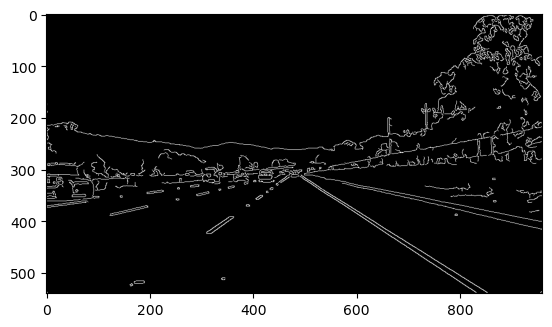

In [3]:
canny_img = canny(np.copy(img), low_thresh=25, upper_thresh=100)
plt.imshow(canny_img, cmap='gray')

### Region of Interest (ROI)

In the final product, we do not want to display the edges of every single object/feature in our image, we only want to focus on the lines on the road ahead of us. To help achieve this, the image can be masked such that only the road ahead is considered for lane detection and all other aspects of the image are ignored. The image below shows the selected region of interest bounded by a border of white.

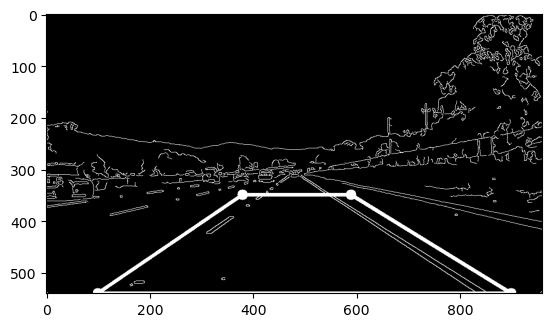

In [28]:
height = canny_img.shape[0]
roi_points = np.array([[
    (100, height), (380, 350), (590, 350), (900, height)
]])

canny_points = draw_roi(np.copy(canny_img), roi_points, (255, 0, 0))
plt.imshow(canny_points, cmap='gray')

Now that we can visualize the ROI, we want to only keep the pixels within the boundries. This can cleverly be accomplished by masking and bitwise `AND` operations. First we create a black image that is the same size as the original image. On top of this, we draw a filled polygram (colour doesn't matter so long it is maximum intensity $255$ of a single channel). The output would look something like:

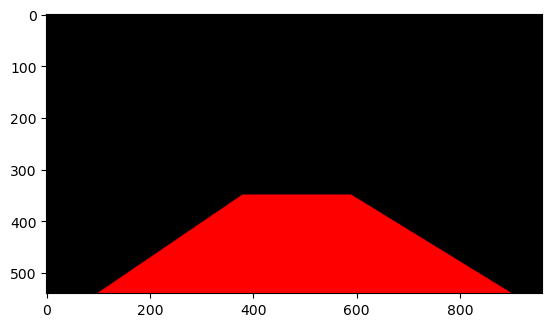

In [30]:
masked_img = roi(np.full_like(img, 255), roi_points)
plt.imshow(masked_img)

We can take this masked image and do a bitwise `AND` operation with the Canny image, which will leave us only the portion of the canny image that exists within the ROI boundries.

The reason this works is the clear use of bitwise `AND`. The masked image has two pixel intensities, black ($00000000_2$) and non-black ($1111111_2$). If we know that the `AND` truth table is as such:

| **A** | **B** | **Y** |
|-------|-------|-------|
| 0     | 0     | **0** |
| 0     | 1     | **0** |
| 1     | 0     | **0** |
| 1     | 1     | **1** |

Performing an `AND` operation between a black pixel and non-black pixel, it will always result in a zero. 

$$00000000 \text{ \& } 10101010 = 00000000$$

Contrarily, if we perform an `AND` operation between a full-intensity pixel and a non-black pixel, the result will alway be the value of the non-black pixel.

$$11111111 \text{ \& } 10101010 = 10101010$$

Let's think about this in terms of our situation. If we perform a bitwise `AND` operation between the Canny image an the masked image, all of the pixels in the Canny image that are in the same location as the black pixels of the masked image will result in black pixels in the canny image. Similarily, all of the pixels in the Canny image that are in the same location of the full-intensity pixels (ROI) in the masked image, will result in the same pixels as in the Canny image.

The image below shows the output of the bitwise `AND` operation between the mask and the Canny image. We can see that the only non-black pixels left are those that existed in the ROI (filled polygon). This image is what we will use to detect the lines going forward.
 

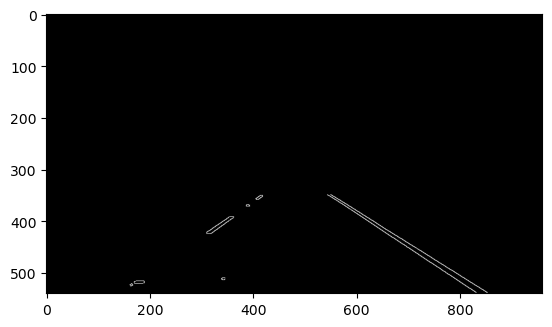

In [31]:
roi_canny_img = roi(canny_img, roi_points)
plt.imshow(roi_canny_img, cmap='gray')

### Hough Lines

Great, so now we have the edges of the lane markers for the lane the vehicle is in. However, the edges alone cannot describe the idea of _lanes_. Lanes can be seperated by solid lines, dashed lines, etc. So far we just know where the edges of theses lines are, what we want to do is draw a line over these edges to describe the left and right lane boundries.

The edges in the previous images are collection of white pixels (points) that don't have any relation to one another. While we can obviously see that they are lines, computers do not. So we need to find a method that can define lines out of these pixels and the **Hough Transforms** is the method that will help us accomplish this.

Rather than going through the complexities of this mathematical concept, I'll link a [video](https://www.youtube.com/watch?v=XRBc_xkZREg) that does a great job explaining how it works.

Below is the output we get by playing around with the Hough transform parameters.

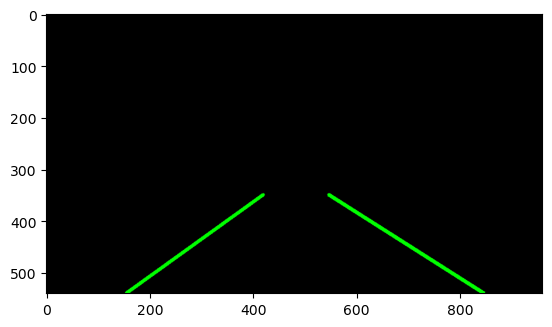

In [6]:
hough_img = hough_lines(roi_canny_img, 2, np.pi/180, 50, 10, 5, roi_points)
plt.imshow(hough_img)

The output above shows the **averaged** lines from the multiple lines that Hough transform gives us. There might originally be 2-3 lines detected for the left line, and 1-2 lines detected for the right lines. Having multiple lines is not useful for us, we only one to have a single line for the left and right lane boudry respectively.

Using the coordinate system from `matplotlib` above, we know that the left lane boundry should have a negative slope and the right lane boundry should have a positive slope.

> Note that `matplotlib` by default uses a inverted y-axis

If there are multiple lines with, for example, negative slopes detected, then we can average out all of those lines to create one single line for the left lane line.

### Weighted Addition

Great! We've got a line representation of the left and right lane markers. Now all we need to do is layer this image on top of the original image. Which can be simply done through cross-disolving the two images.

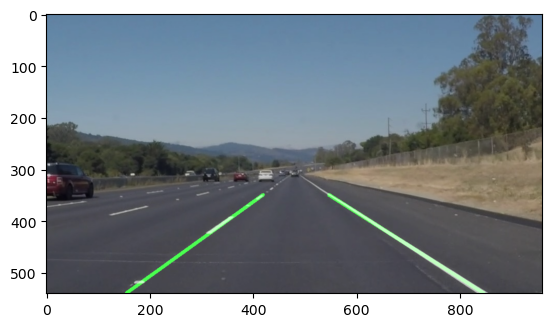

In [33]:
lane_img = np.copy(img)

lane_img = cv2.addWeighted(lane_img, 0.8, hough_img, 1.0, 0)
plt.imshow(lane_img)

## Pipeline

Now that we have successfully detected the lane, let's our pipeline function which runs all of the functions we went through above sequentially. All we need to do is pass an image and the ROI points. 

We have defined an image and the ROI points previously. We'll keep the ROI points previously defined, but let's try out a new test image.

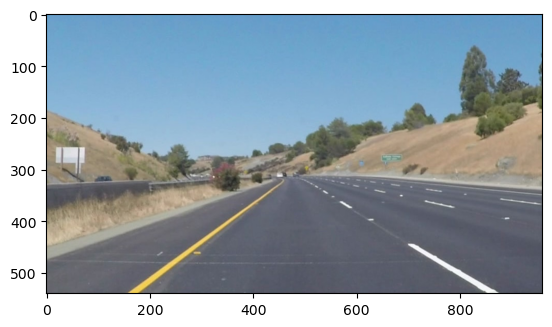

In [9]:
new_img = cv2.imread('test_images/solidYellowCurve2.jpg')
new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB)
plt.imshow(new_img)

Running the full pipeline:

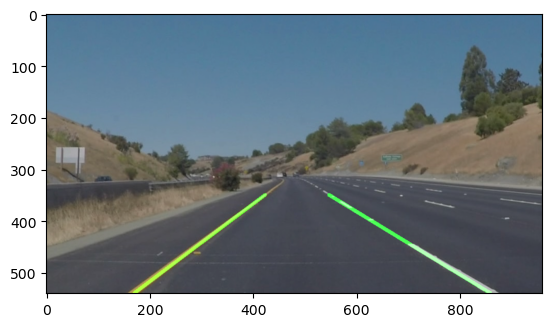

In [10]:
result = pipeline(new_img, roi_points)
plt.imshow(result)

And there we have it! We can see that our pipeline works well on a new test image. Next let's see how we can display these lines on a video.

## Video

In [16]:
cap = cv2.VideoCapture('test_videos/solidWhiteRight.mp4')
out = cv2.VideoWriter('output.avi', cv2.VideoWriter_fourcc(*"MJPG"), 24, (960, 540))

while(cap.isOpened()):
    ret, frame = cap.read()

    if not ret:
        print("Can't receive frame (stream end?). Exiting...")
        break

    result = pipeline(frame, roi_points)
    out.write(result.astype('uint8'))
    cv2.imshow('Result', result)
    cv2.waitKey(10)
    
    if cv2.waitKey(1) == ord('q'):
        break

cap.release()
out.release()
cv2.destroyAllWindows()

Can't receive frame (stream end?). Exiting...


Here is the output of the code above as a gif so you don't have to run it. Looks like this lane detection method works well with this video example!

![SegmentLocal](results/video_result.gif "segment")

The next step after this is to apply this method to curved roads. As of right now, this method limited to straight roads because applied Hough trasnform works only with straight lines.